In [1]:
#Graph_Construction_Defining_the_problem

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [2]:
#given_distance_matrix_&_list_of_node_labels_that_are_relevant_for_this_graph
def draw_graph(node_labels, dist_matrix):
    #take_subset_of_node_labels_that_are_relevnt_for_this_graph
    node_labels={i:node_labels[i] for i in range(dist_matrix.shape[0])}
    #convert_to_integers_for_better_understanding
    dist_matrix=np.array(dist_matrix, dtype=int)
    
    #construct_graph_from_matrix
    G=nx.from_numpy_array(dist_matrix)
    
    #define_layout_nodes_around_paramter_of_circle
    pos=nx.shell_layout(G)
    
    #draw_vertices
    options={"node_size":500, "alpha":0.8, "node_color":"tab:blue"}
    nx.draw_networkx_nodes(G, pos, **options)
    options={"font_size":15, "font_color":"whitesmoke"}
    nx.draw_networkx_labels(G, pos, node_labels, **options)
    
    #draw_edges
    options={"width":1, "edge_color":"tab:gray", "alpha":0.5}
    nx.draw_networkx_edges(G, pos, **options)
    options={"font_size":7, "font_color":"black", "label_pos":0.42}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), **options)
    
    #display_graph
    plt.axis("off")
    plt.savefig("Graph.png")
    plt.show()

In [3]:
#build_matrix_given_nodes_populate_with_random_values_symmetric_matrix_zeros_in_leading_diagonal
def generate_graph(num_nodes):
    m=np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i):
            rand=random.randint(2, 30)
            m[i][j]=rand
            m[j][i]=rand
    return m

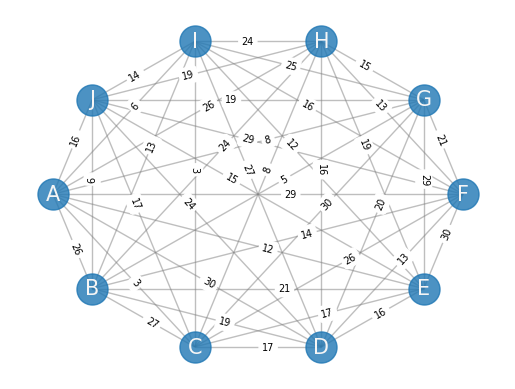

In [4]:
node_labels={0:"A", 1:"B", 2:"C", 3:"D", 4:"E", 5:"F", 6:"G", 7:"H", 8:"I", 9:"J", 10:"K", 11:"L", 12:"M", 13:"N", 14:"O"}
m=generate_graph(10)
draw_graph(node_labels, m)

In [6]:
#Nearest_Neighbour_Algorithm
def nearest_neighbour(distance_matrix):
    m=distance_matrix.copy()
    start=previous=0
    nodes=m.shape[0]
    m[previous, :]=[np.inf for i in range(nodes)]
    
    #output_variables
    tour=[previous]
    total_cost=0
    
    #repeatedly_find_cheapest_node
    for i in range(nodes-1):
        nearest=np.argmin(m[:, previous])
        tour+=[nearest]
        total_cost+=m[nearest, previous]
        
        previous=nearest
        m[nearest, :]=[np.inf for i in range(nodes)]
        
    #return_to_start
    total_cost+=distance_matrix[start, previous]
    tour+=[start]
    return (tour, int(total_cost))
    

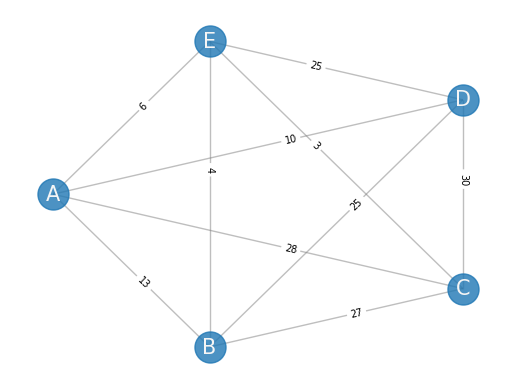

Tour: ['A', 'E', 'C', 'B', 'D', 'A']
Cost: 71


In [9]:
#testing
m=generate_graph(5)
draw_graph(node_labels, m)

tour, cost=nearest_neighbour(m.copy())
tour=[node_labels[i] for i in tour]
print("Tour:", tour)
print("Cost:", cost)

In [10]:
#Genetic_Algorithm_Approach
#Build_our_initial_population_of_chromosomes
#each_chromosome_describe_sequence_in_which_we_visit_nodes_of_graph
#Not_include_start_or_node_in_our_chromosome_as_they_will_complicate_crossover_&_mutation
#by_random_permutation_of_nodes

def generate_initial_population(num_nodes, pop_size):
    nodes=[i for i in range(1, num_nodes)]
    population=[]
    for i in range(pop_size):
        random.shuffle(nodes)
        population.append(nodes.copy())
    return population

In [11]:
#fitness_Fn-evaluate_success_Of_chromosome
#fitness_score_is_total_length_of_cycle_described_by_chromosome
def fitness(chromosome, m):
    score=0
    for i, gene in enumerate(chromosome):
        if i==0:
            score+=m[0, gene]
        else:
            score+=m[gene, chromosome[i-1]]
    score+=m[0, chromosome[-1]]
    return 100/score

In [12]:
def genetic_algorithm(population, iterations, selection, crossover, crossover_threshold, mutation, mutation_threshold, elitism):
    pop_size=len(population)
    
    mean_fitness_score=[]
    best_fitness_score=[]
    
    #evaluate_initial_population
    fitness_scores=[fitness(i, m) for i in population]
    
    #sort_initial_population
    order=np.array(sorted([*enumerate(fitness_scores)], key=lambda x:x[1], reverse=True), dtype=int)[:, 0]
    population=[population[i] for i in order]
    fitness_scores=sorted(fitness_scores, reverse=True)
    
    #generation_loop
    for iter in range(iterations):
        new_pop=copy.deepcopy(population)
        replaced=elitism
        
        #build_new_population
        while(replaced<pop_size):
            #selection
            index=selection(pop_size, fitness_scores)
            
            #crossover
            if random.random()<crossover_threshold:
                child1, child2=crossover(population[index[0]].copy(), population[index[1]].copy())
            else:
                child1, child2=population[index[0]].copy(), population[index[1]].copy()
                
            #mutation
            if random.random()<mutation_threshold:
                child1=mutation(child1)
            if random.random()<mutation_threshold:
                child2=mutation(child2)
                
            #replacement
            new_pop[replaced]=child1
            replaced+=1
            if replaced<pop_size:
                new_pop[replaced]=child2
                replaced+=1
        
        #evaluation
        population=new_pop
        fitness_scores=[fitness(i, m) for i in population]
        
        #sort_population_by_fitness
        order=np.array(sorted([*enumerate(fitness_scores)], key=lambda x:x[1], reverse=True), dtype=int)[:, 0]
        population=[population[i] for i in order]
        fitness_scores=sorted(fitness_scores, reverse=True)
        
        #calculate_mean_&_max_fitness_score
        mean_fitness_score.append(np.mean(fitness_scores))
        best_fitness_score.append(fitness_scores[0])
        
    return (mean_fitness_score, best_fitness_score, population[0].copy())

In [13]:
#roulette_wheel_selection
#weighted_random_selection_based_on_fitness_score_value

def roulette_wheel_selection(pop_size, fitness_scores):
    return (random.choices(range(pop_size), weights=fitness_scores, k=2))

#replace_random_subset_of_elements_in_order_in_which_they_appear_in_other_chromosome
def order_crossover(x1, x2):
    values=np.random.choice(x1, size=3, replace=False)
    x1_index=[i for i in range(len(x1)) if x1[i] in values]
    x2_index=[i for i in range(len(x2)) if x2[i] in values]
    temp=[i for i in x1 if i in values]
    x1[x1_index[0]], x1[x1_index[1]], x1[x1_index[2]]=x2[x2_index[0]], x2[x2_index[1]], x2[x2_index[2]]
    x2[x2_index[0]], x2[x2_index[1]], x2[x2_index[2]]=temp[0], temp[1], temp[2]
    
    return x1, x2

#swap_mutation_swap_2_values_in_chromosome
def mutate1(x):
    index=np.random.choice(range(len(x)), size=2, replace=False)
    temp=x[index[0]]
    x[index[0]]=x[index[1]]
    x[index[1]]=temp
    return x

#random_insertion_remove_a_value_and_re_insert_it_in_random_position_in_chromosome
def mutate2(x):
    index=random.choice(range(len(x)))
    temp=x[index]
    x.remove(temp)
    x.insert(random.choice(range(len(x))), temp)
    return x

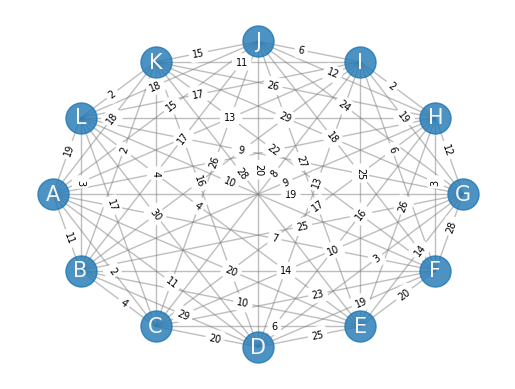

Random Initial Tour:['A', 'D', 'I', 'L', 'G', 'E', 'F', 'K', 'C', 'B', 'J', 'H', 'A'], Weight:172.0


In [14]:
#parameters
iterations=250
pop_size=300

num_nodes=12
m=generate_graph(num_nodes)

draw_graph(node_labels, m)

#generate_initial_population
population=generate_initial_population(num_nodes=num_nodes, pop_size=pop_size)

#display_pre_GA_random_route
tour=["A"]+[node_labels[i] for i in population[0]]+["A"]
print(f"Random Initial Tour:{tour}, Weight:{100/fitness(population[0], m)}")

#run_genetic_algorithm
mean_fitness, best_fitness, tour=genetic_algorithm(population=population,
                                                  iterations=iterations,
                                                  selection=roulette_wheel_selection, crossover=order_crossover,
                                                  crossover_threshold=0.7, mutation=mutate1,
                                                  mutation_threshold=0.25, elitism=1)

Best Tour:['A', 'D', 'G', 'H', 'F', 'I', 'J', 'K', 'B', 'L', 'E', 'C', 'A'], Weight:73.0


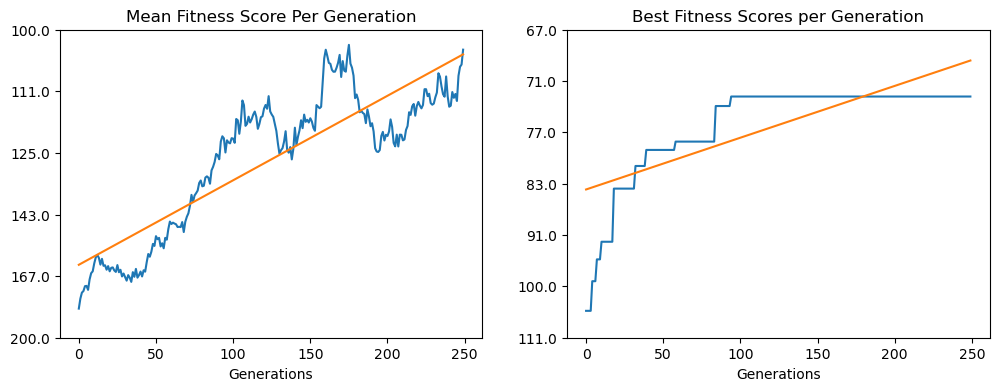


Nearest Neighbour tour: ['A', 'C', 'B', 'K', 'L', 'E', 'G', 'D', 'I', 'H', 'F', 'J', 'A']

Nearest Neighbour Cost: 82


In [15]:
#display_post_GA_best_route
tour=["A"]+[node_labels[i] for i in tour] + ["A"]
print(f"Best Tour:{tour}, Weight:{np.round(100/best_fitness[-1])}")

x=range(iterations)

fig, ax=plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(x, mean_fitness)
ax[0].set_title("Mean Fitness Score Per Generation")
a, b=np.polyfit(x, mean_fitness, 1)
ax[0].plot(x, a*x+b)
ax[0].set_xlabel("Generations")

ax[1].plot(x, best_fitness)
ax[1].set_title("Best Fitness Scores per Generation")
a, b=np.polyfit(x, best_fitness, 1)
if len(set(best_fitness))!=1: #only_shows_best_fit_line_when_best_route_found_in_initial_population
    ax[1].plot(x, a*x+b)
ax[1].set_xlabel("Generations")

#translate_fitness_scoresback_into_route_weights
y_ticks=ax[0].get_yticks()
y_ticks_formatted=np.round(100/y_ticks, 0)
ax[0].set_yticks(y_ticks, y_ticks_formatted)

y_ticks=ax[1].get_yticks()
y_ticks_formatted=np.round(100/y_ticks, 0)
ax[1].set_yticks(y_ticks, y_ticks_formatted)

#show_graphs
plt.savefig("Results.png")
plt.show()

#by_Nearest_neighbour_approach_for_comparison
tour, cost=nearest_neighbour(m.copy())
tour=[node_labels[i] for i in tour]
print("\nNearest Neighbour tour:", tour)
print("\nNearest Neighbour Cost:", cost)